# Titanic

**Titanic data set as example to practice data science skills from problem formulation to model evaluation and selection**  

**Part 1.** - define objective, evaluation metric and benchmark for the titanic data set <br>
**Part 2.** - exploratory data analysis <br>
**Part 3.** - data prepararation, cleaning and feature engineering <br>
**Part 4.** - deep dive example: decision tree <br>
**Part 5.** - multi-model optimization, incl. ensemble

In [30]:
# import some useful libraries...

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Data

Downloaded train.csv and test.csv from [Kaggle](https://www.kaggle.com/c/titanic/data)

In [29]:
# Create dataframes for train and test

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## 1. Experimental setup

We start by defining what we want to achieve, how we are going to measure success and by creating a benchmark to measure much we are improving

**[...] Objective**: Predict whether a passenger on the Titanic survived or not <br>
**[...] Evaluation metric**: Accuracy <br>
**[1.1] Benchmark**: Majority class

### 1.1 Benchmark

A simple benchmark to measure progress against is predicting the majority class

In [15]:
print('% survived:',np.sum(df_train['Survived']==1)/df_train['Survived'].count())
print('% not_survived:', np.sum(df_train['Survived']==0)/df_train['Survived'].count())

# Benchmark will be ~62% for always predicting a passenger did not survive

% survived: 0.383838383838
% not_survived: 0.616161616162


## 2. Exploratory data analysis

### Overall notes based on exploration below

#### Missing observations
* Cabin has a lot of missing observations. Cannot fill in a reasonable way, but also do not want to throw away that much data. Ergo, will include 'X' later in cleaning to fill (absence of information is also information)
* Age also has a lot of missing obersvations. We can either fill these with the average, or choose to be more sophisticated. Age might e.g., correlate well with title in 'Name'
* Embarked only has two missing observations. Since I don't want to do a lot of work for just two rows, I will use the most prevalent class to fill

#### Distribution of each variable / Normalize
* For certain classifiers it will be important to normalize the variables. Eg 'Pclass', 'Age' and 'Fare' are quite different in order of magnitude.

#### Correlation
* None of the variables are very strongly correlated
* Some intuitive correlations, e.g.,:
    * Pclass and survival (lower class number = more premium = closer to deck = higher chance of survival)
    * Pclass and Age (older people are wealthier and buy more premium rooms)
    * Pclass and Fare (lower class = more premium = more expensive)
    * ... Gender and survival is probably also highly correlated, but we'll see that later once we clean/prep the data

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [420]:
print('Features: ', df_train.columns)
print('Dimensions: ', df_train.shape)
print('Data types: ', df_train.dtypes.unique())

Features:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Dimensions:  (891, 12)
Data types:  [dtype('int64') dtype('O') dtype('float64')]


In [421]:
data_table = pd.DataFrame(columns = ['data_type', 'num_obs', 'missing_obs', 'unique_obs'])
data_table['data_type'] = df_train.dtypes
data_table['num_obs'] = df_train.count()
data_table['missing_obs']  = df_train.isnull().sum()
data_table['unique_obs'] = df_train.nunique()

data_table

,data_type,num_obs,missing_obs,unique_obs
PassengerId,int64,891,0,891
Survived,int64,891,0,2
Pclass,int64,891,0,3
Name,object,891,0,891
Sex,object,891,0,2
Age,float64,714,177,88
SibSp,int64,891,0,7
Parch,int64,891,0,7
Ticket,object,891,0,681
Fare,float64,891,0,248


In [422]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [423]:
df_train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Wilhelms, Mr. Charles",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


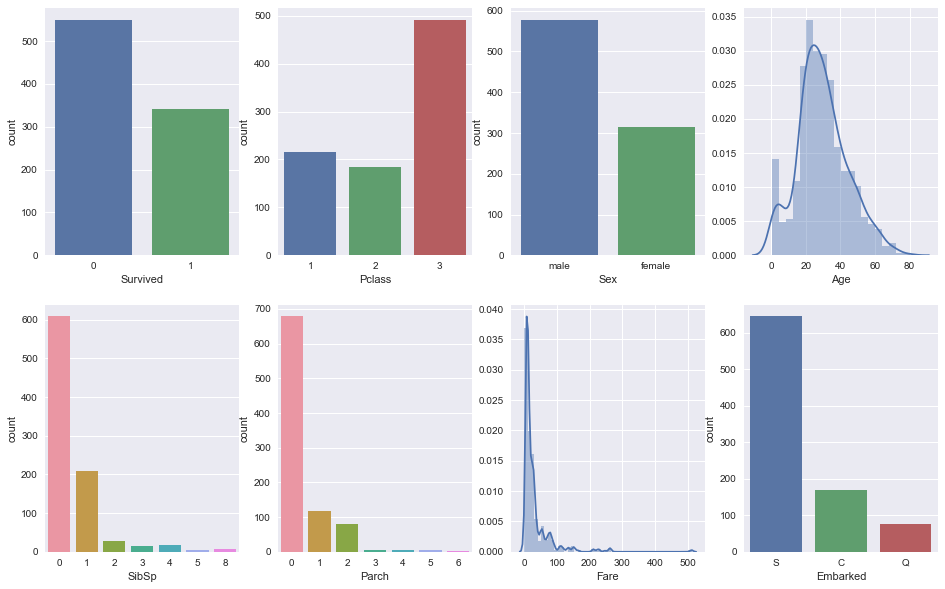

In [424]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10));
sns.countplot('Survived',data=df_train,ax=axes[0,0])
sns.countplot('Pclass',data=df_train,ax=axes[0,1])
sns.countplot('Sex',data=df_train,ax=axes[0,2])
sns.distplot(df_train['Age'].dropna(), ax=axes[0,3])
sns.countplot('SibSp',data=df_train,ax=axes[1,0])
sns.countplot('Parch',data=df_train,ax=axes[1,1])
sns.distplot(df_train['Fare'],ax=axes[1,2])
sns.countplot('Embarked',data=df_train,ax=axes[1,3])

plt.show();

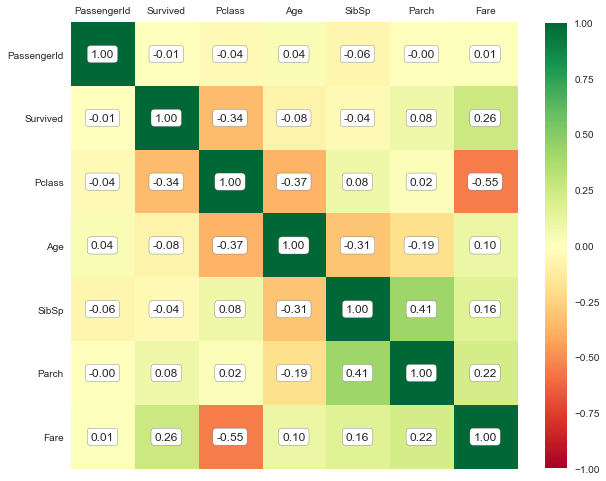

In [425]:
# create data for the correlation matrix
data = df_train.corr();

# create a figure object, add one subplot and make it a bit larger / easier to see
fig, ax = plt.subplots(figsize=(10, 10));
cax = ax.matshow(data, cmap='RdYlGn', vmin = -1, vmax = 1);

plt.xticks(range(len(data.columns)), data.columns);
plt.yticks(range(len(data.columns)), data.columns);

fig.colorbar(cax, fraction = 0.15, shrink = 0.82);

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.grid(axis='both', b=0)

# show result
plt.show();

### 2.1 Correlates of survival

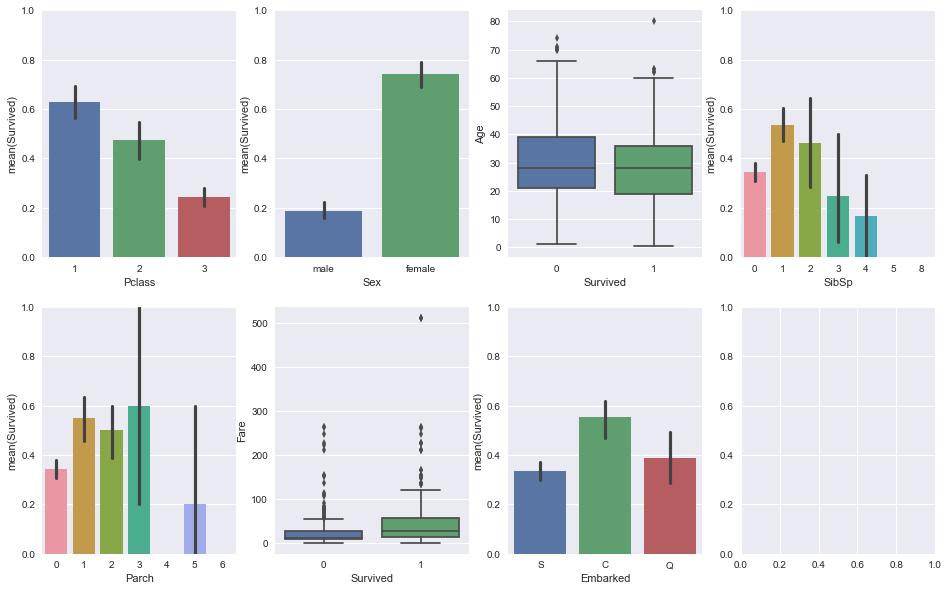

In [148]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

sns.barplot(x='Pclass', y='Survived',data=df_train,ax=axes[0,0]).set_ylim(0,1)
sns.barplot(x='Sex', y='Survived',data=df_train,ax=axes[0,1]).set_ylim(0,1)
sns.boxplot(x='Survived', y='Age', data=df_train,ax=axes[0,2])
sns.barplot(x='SibSp', y='Survived',data=df_train,ax=axes[0,3]).set_ylim(0,1)
sns.barplot(x='Parch', y='Survived',data=df_train,ax=axes[1,0]).set_ylim(0,1)
sns.boxplot(x='Survived', y='Fare', data=df_train,ax=axes[1,1])
sns.barplot(x='Embarked', y='Survived',data=df_train,ax=axes[1,2]).set_ylim(0,1)
plt.show()

### Observations
**Most important factors:**
* Gender: Being female greatly enhances chance of survival (greatest diff ~.6)
* Class: People that could afford a premium room near top deck had much greater chance of survival (greatest diff ~.4)
* Siblings/Spouse: Having one kid/spouse was good for survival, but it drops after (greatest diff ~.4)
* Embarked: Where you boarded matters. This might be correlated with eg wealth, thus Class (greatest diff ~.2)
* Parents/Children: Not much variation if we exclude value of 5
  

* Age: Average and distribution of survivors is slightly lower, but not by much
* Fare: Paying a higher fare helped, as suspected from the correlation with Class


## 3.  Data preparation, cleaning and feature engineering

General data preparation and cleaning. Later on, depending on the algorithm used some addition transformations might be necessary <br>(e.g., numerical vs. one-hot encoding)

### Notes:
* Drop features: I will drop 'Ticket' as I don't see any useful information in addition to e.g., fare
* NaN values: 
    * Age: Fill with average age based on title (analysis to be done here after)
    * Cabin: Fill NaN values with 'X'
    * Embarked:  Fill with most prevalent class = 'C'
* Normalization: Not needed for decision trees
* Encoding/binning: 
    * Name: Will extract title only
    * Age: Bin according to age, e.g.:Baby, Child, Teenager, (young) adult, senior
    * Cabin: Use first letter only, 'X' for NaN
    * Fare: Bin according to quartiles we found via describe(). Fill with most common quartile for Pclass if NaN

In [31]:
# First, create 'raw' copy of data
df_train_raw = df_train.copy(deep=True)
df_test_raw = df_test.copy(deep=True)

In [32]:
# Age - fillna (see next paragraph, more involved steps)

# Cabin
df_train['Cabin'] = df_train['Cabin'].fillna('X')
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: x[0])


# Embarked
df_train['Embarked'] = df_train['Embarked'].fillna('C')

# Name - extract title
df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Age - bucketing
bins = (0, 5, 12, 18, 30, 60, 100) # based on quartiles and visual inspection distribution plot
labels = ['Baby', 'Child', 'Teenager','Young Adult', 'Adult', 'Senior']
df_train['Age'] = pd.cut(df_train['Age'], bins, labels=labels)

# Cabin (see above)

# Fare (see further below for fillna)
bins = (0, 8, 15, 31, 520) # based on quartiles
labels = ['1st_Q', '2nd_Q', '3rd_Q','4th_Q']
df_train['Fare'] = pd.cut(df_train['Fare'], bins, labels=labels)

In [33]:
# Age - fillna (based on typical age of a person with a certain title)
# Create Age and Title lookup table
Age_Title_pivot = pd.pivot_table(data = df_train, values = 'Survived', index = 'Title', columns = 'Age', aggfunc = 'count')
Age_Title_lookup = Age_Title_pivot.apply(lambda x: np.argmax(x, axis=0), axis = 1)

# Create index list of Age NaN values and corresponding Pclass number
nulls = df_train.loc[df_train['Age'].isnull(), 'Title']

# Fill Age NaNs with lookup
df_train.loc[df_train['Age'].isnull(), 'Age'] = Age_Title_lookup.loc[nulls].values


In [34]:
# Fare - fillna (based on typical quartile given a Pclass)
# Create quartile and Pclass lookup table
Pclass_Fare_pivot = pd.pivot_table(data = df_train, values = 'Survived', index = 'Pclass', columns = 'Fare', aggfunc = 'count')
Pclass_Fare_lookup = Pclass_Fare_pivot.apply(lambda x: np.argmax(x, axis=0), axis = 1)

# Create index list of Fare NaN values and corresponding Pclass number
nulls = df_train.loc[df_train['Fare'].isnull(), 'Pclass']

# Fill Age NaNs with lookup
df_train.loc[df_train['Fare'].isnull(), 'Fare'] = Pclass_Fare_lookup.loc[nulls].values

In [35]:
# Drop features we will not use (Name, Ticket)
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null category
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null category
Cabin       891 non-null object
Embarked    891 non-null object
Title       891 non-null object
dtypes: category(2), int64(4), object(4)
memory usage: 57.9+ KB


In [37]:
# OOOOPS - forgot I also have to do this for the test set
# Would have been better to define functions or firast  :-(

# Cabin
df_test['Cabin'] = df_test['Cabin'].fillna('X')
df_test['Cabin'] = df_test['Cabin'].apply(lambda x: x[0])

# Name - extract title and drop Name
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Age - bucketing
bins = (0, 5, 12, 18, 30, 60, 100) # based on quartiles and visual inspection distribution plot of train
labels = ['Baby', 'Child', 'Teenager','Young Adult', 'Adult', 'Senior']
df_test['Age'] = pd.cut(df_test['Age'], bins, labels=labels)

# Age - fillna using train lookup for consistency
nulls = df_test.loc[df_test['Age'].isnull(), 'Title']
df_test.loc[df_test['Age'].isnull(), 'Age'] = Age_Title_lookup.loc[nulls].values

# Fare - bucketing
bins = (0, 8, 15, 31, 520) # based on quartiles
labels = ['1st_Q', '2nd_Q', '3rd_Q','4th_Q']
df_test['Fare'] = pd.cut(df_test['Fare'], bins, labels=labels)

# Fare - fillna using train lookup for consistency
nulls = df_test.loc[df_test['Fare'].isnull(), 'Pclass']
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = Pclass_Fare_lookup.loc[nulls].values

In [38]:
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null category
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null category
Cabin       418 non-null object
Embarked    418 non-null object
Title       418 non-null object
dtypes: category(2), int64(3), object(4)
memory usage: 24.1+ KB


In [40]:
# Some data bookkeeping ...
df_test_clean = df_test.copy(deep=True) # for other models later
df_train_clean = df_train.copy(deep=True)

df_test_numcat = df_test.copy(deep=True) # for decision trees
df_train_numcat = df_train.copy(deep=True)

## 4.  Deep dive example: Decision tree

In [41]:
# Specific data prep  for decision tree: convert categorical variables into numerical
# Note: Numerical outperforms one-hot encoding for trees (scale invariant to numerical (so fine), but one-hot creates huge trees)

# Use LabelEncoder to quickly transform features into numerical categories
from sklearn import preprocessing
def num_encoder(df_train, df_test):
    features = ['Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title']
    df_total = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_total[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

df_train_numcat, df_test_numcat = num_encoder(df_train_numcat, df_test_numcat)

In [42]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score

# create data format
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

# Initialize classifier
clf = DecisionTreeClassifier(random_state=42)

# Do cross-validation
acc = make_scorer(accuracy_score)
scores = cross_validate(clf, df_data, df_target, scoring = acc, cv=10, return_train_score=True)

print('Average Training score: ', np.average(scores['train_score']))
print('Average Test score: ', np.average(scores['test_score']))

Average Training score:  0.91856887675
Average Test score:  0.813778799228


In [44]:
# Feature importance
clf = clf.fit(df_data, df_target)

feature_table = pd.DataFrame(data = [clf.feature_importances_], index = ['Importance'], columns = df_data.columns)
feature_table.sort_values(by = 'Importance', axis = 1, ascending = False)

,Sex,Pclass,Cabin,SibSp,Title,Age,Fare,Embarked,Parch
Importance,0.397172,0.109405,0.09417,0.082566,0.07998,0.076032,0.069361,0.052414,0.038902


### Observations
* **Results:** The avg training score is very high (91%) and much higher than the avg test score (81%). Tree is likely overfitting.
* **Features:**
    * Sex: (being female) indeed most important
    * Socio-economic status: Pclass/Title are most important after ; Title is also important, but only for men
    * "Women and children first" does not seem immediatly obvious from these results (Age/SibSp not not that important)
    * First 3/4 levels of tree still intuitive, but interpretation beocomes difficult further down
* Sidenote: the Title category might be improved as the numerical labels have no order in them and there are many classes. This might make it hard for the algorithm to make the most effective split.

### 4.1 Tree tuning

Show tree diagram, chose max_depth = 4

In [45]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score

# data
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

# Initialize classifier
clf = DecisionTreeClassifier(max_depth = 4, random_state=42)
clf = clf.fit(df_data, df_target)

print('Average Training score: ', clf.score(df_data, df_target))

Average Training score:  0.832772166105


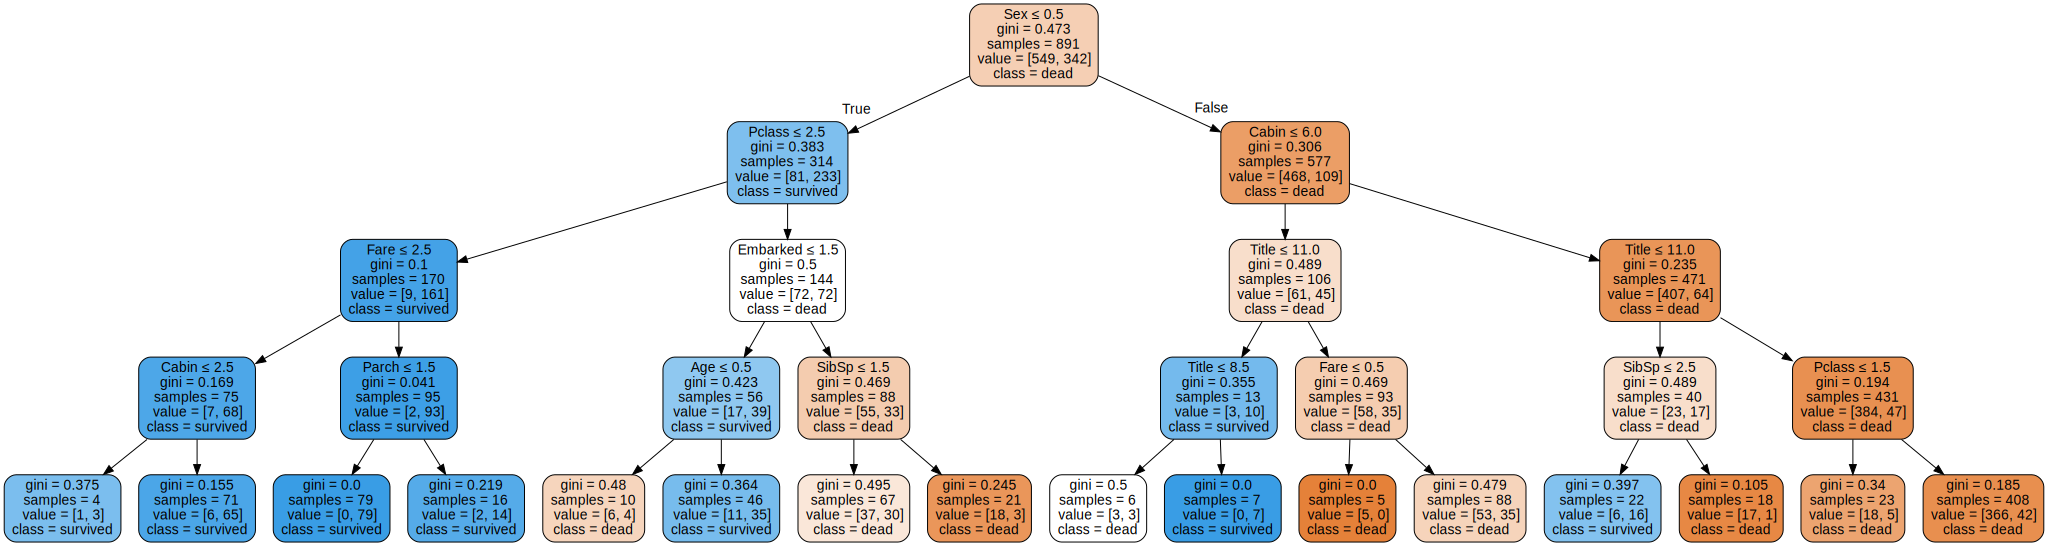

In [387]:
#Plot tree
dot_data = tree.export_graphviz(clf, out_file=None, \
                         feature_names=df_data.columns, class_names = ['dead', 'survived'],\
                         filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [112]:
# Show fature importance
feature_table2 = pd.DataFrame(data = [clf.feature_importances_], index = ['Importance'], columns = df_data.columns)
feature_table2 = feature_table2.sort_values(by = 'Importance', axis = 1, ascending = False).copy(deep=True)
feature_table2

,Sex,Pclass,Cabin,Title,SibSp,Embarked,Age,Fare,Parch
Importance,0.601972,0.153526,0.070759,0.060205,0.057604,0.034211,0.010351,0.00936,0.002012


### Observations
* **Results:** training score now ~83% (closer to test score earlier). Constraining tree depth seems to help prevent overfitting.
* **Features:**
    * Sex: (being female) even more important
    * Socio-economic status: Pclass/Cabin are most important after ; Title is also important, but only for men
        * (cabin is the cabin letter A- ..., where A was closer to top deck, so that makes sense)
    * More intuitive to understand now, although I would still make sure to sort Title somehow next time (eg common vs rare titles, or in order of socio-economic status and age)

### 4.2 Sensitivity analysis for tuning hyper parameters

### First, show how max_depth affects train and test accuracy

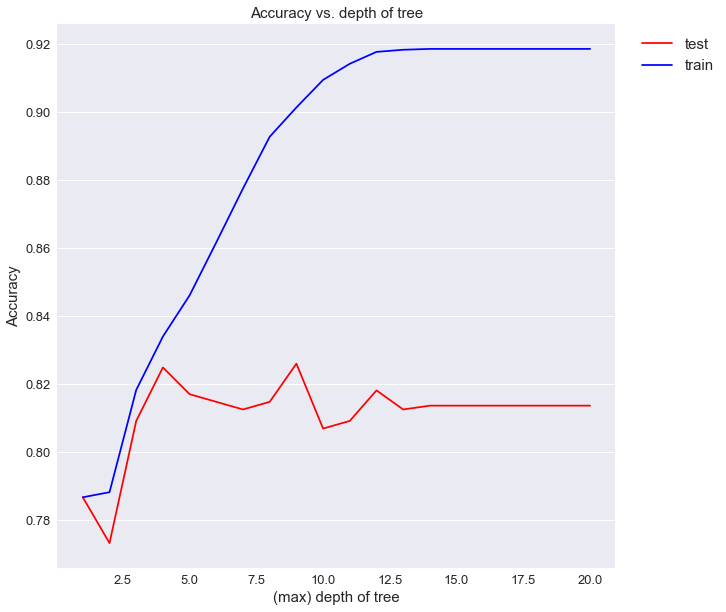

In [439]:
# Set parameters for GridSearch
parameters = {'max_depth': np.arange(1,21)}

# Initialize classifier
clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

results = pd.DataFrame(clf.cv_results_)

# Graph results
fig, ax = plt.subplots(figsize = (10,10))

x = results['param_max_depth']
y_test = results['mean_test_score']
y_train = results['mean_train_score']

ax.plot(x, y_test, color = 'r',  label = 'test')
ax.plot(x, y_train, color = 'b',  label = 'train')

plt.title('Accuracy vs. depth of tree', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('(max) depth of tree', fontsize = 15)

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='x', b=0)

plt.tick_params(axis='both', which='major', labelsize=13)

plt.show()


### Second, show how test accuracy relates to both max_depth and min_samples_leaf.

In [705]:
from sklearn.model_selection import GridSearchCV

# Set parameters for GridSearch
parameters = {'max_depth': np.arange(1,21), 'min_samples_leaf': np.arange(1,50)}

# Initialize classifier
clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

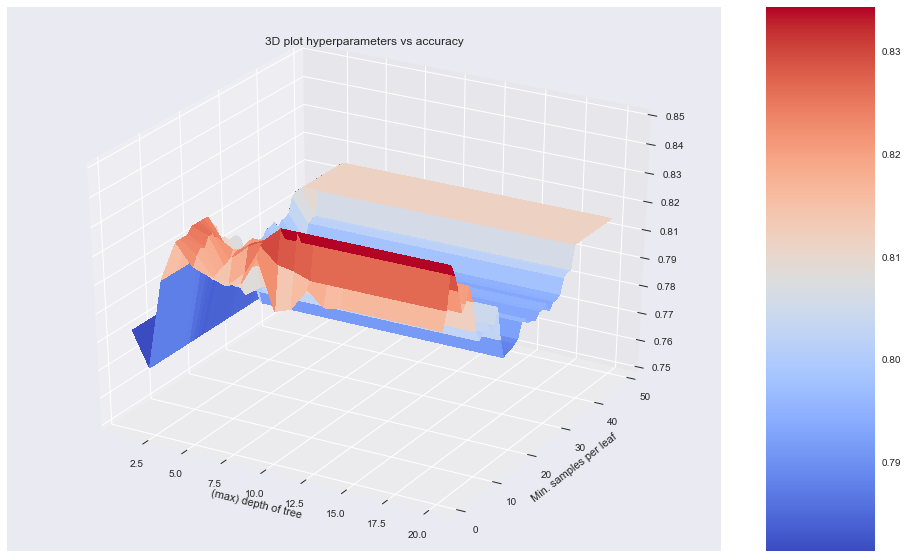

In [706]:
# Results
results = pd.DataFrame(clf.cv_results_)

# Graph results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata


x = np.linspace(results['param_max_depth'].min(), results['param_max_depth'].max(), len(results['param_max_depth'].unique()))
y = np.linspace(results['param_min_samples_leaf'].min(), results['param_min_samples_leaf'].max(), len(results['param_min_samples_leaf'].unique()))
z = results['mean_test_score']

X, Y = np.meshgrid(x, y)
Z = griddata((results['param_max_depth'], results['param_min_samples_leaf']), z, (X, Y), method='cubic')

fig = plt.figure(figsize = (16,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
ax.set_zlim(0.75, 0.85)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=1, aspect=5)
plt.title('3D plot hyperparameters vs accuracy')

plt.xlabel('(max) depth of tree')
plt.ylabel('Min. samples per leaf')

plt.show()


In [709]:
# Highest accuracy
results[results.mean_test_score== results.mean_test_score.max()].head(1)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
443,0.001,0.001,0.836139,0.87991,10,3,"{'max_depth': 10, 'min_samples_leaf': 3}",1,0.788889,0.877653,...,0.820225,0.879052,0.842697,0.877805,0.852273,0.877958,0.003,0.003,0.038608,0.004527


### Observations

* **First step, max_depth and accuracy**
    * Too shallow a tree will lead to bias, i.e. underfit on the data. You see the bad performance for both train and test
    * As expected, with increasing depth the decision tree will overfit on the training set (increase train accuracy)
    * The impact on test accuracy isn't too big here (fluctuating, a few %pts). I would expect peformance on the training set to go down with increasing depth  (because of too high variance / overfitting on training data). Part of the explanation could be that the tree doesn't go very deep before it can't make further splits based on samples left. Ie max_depth of >10 is basically the same as max_depth 10 here. 
* **Second step, max_depth + min_samples_leaf  and accuracy**
    * A combination of max_depth = 10 and min_samples_leaf = 3 achieves the highest test accuracy. This is slightly better performance than just hypertuning max_depth
    * It makes sense that performance is highest, because the two hyperparameters work a bit like regularization, i.e. max_depth allows more and more 'interactions/variables'= splits and min_samples acts as regularization to prevent overfitting on each individual sample
    * The performance is roughly equally sensitive to these parameters (~78%-84%). This is what you would expect, since min_samples and max_depth are very close related (specifying a small min_sample is the same as a big max_depth ; low max_depth implies big min_samples)
    * Overall, a difference of ~6%pts means the performance is quite sensitive to these hyperparameters
    * Although roughly equal range, sensitivity for depth/leafs differs based on what part of the graph you are at, eg:
        * At low max_depth, adding a new layer of depth has a much bigger impact in terms of samples than min_samples (in fact, requiring min 1 or min 10 samples probably doesnt matter yet as all splits will have 30+ samples left)
        * At high max_depth (ie 1-3 samples left per leaf), requiring a higher min_samples per leaf will have a big impact because it can constrain max_depth significantly

## 5. Multi model optimization and evaluation

Here I tune and compare a larger set of models, incl. an ensemble of all of them. 
* Trees: Decision tree, Random Forest, Gradient Boosted Tree
* Logistic Regression, incl. LASSO / Ridge Regression
* k-Nearest Neighbors
* Multi-layer perceptron

### Notes on providing same data to each algorithm in a sensible way 
* I used the same data for each algorithm, but with two different approaches to converting data into categories:
    * Numerical categories: tree, rf gbtree. Decision trees handle numcat better in terms of splitting (vs. many one-hot splits)
    * One-hot: lassoreg, knn, MLP. One-hot here serves as a form of normalization. This is important for regularized regression (LASSO) and distance based classifiers (knn). It will never hurt for MLP since a randomly assigned higher/lower encoding should not contain any information (also, 'when in doubt')

In [27]:
# Create some dataframes for our output 
clf_list = ['tree', 'rf', 'gbtree', 'lassoreg', 'knn', 'mlp']

results_acc = pd.DataFrame(index = clf_list, columns = ['test', 'train'])
results_auc = pd.DataFrame(index = clf_list, columns = ['test', 'train'])
predictions = pd.DataFrame(index = np.arange(0,len(df_data)), columns = clf_list)

In [28]:
# Create a function to automatically store our results

def store_results_cv(clf, df_data, ml):
    results_acc.loc[ml, 'test'] = clf.cv_results_['mean_test_accuracy'][clf.cv_results_['rank_test_accuracy'] == 1][0]
    results_acc.loc[ml, 'train'] = clf.cv_results_['mean_train_accuracy'][clf.cv_results_['rank_test_accuracy'] == 1][0]
    
    results_auc.loc[ml, 'test'] = clf.cv_results_['mean_test_roc_auc'][clf.cv_results_['rank_test_roc_auc'] == 1][0]
    results_auc.loc[ml, 'train'] = clf.cv_results_['mean_train_roc_auc'][clf.cv_results_['rank_test_roc_auc'] == 1][0]
    
    predictions[ml] = clf.predict(df_data)

In [29]:
# Create a function to run all the regressions

def run_algorithm_cv(df_data, df_target, ml, cv=10):
    
    # Set seed
    np.random.seed(seed=42)
    
    # import models
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import GridSearchCV

    
    # Initialize classifier and set parameter search optimization grid
    if ml == 'tree':
        algo = DecisionTreeClassifier() 
        parameters = {'max_depth': [10], 'min_samples_leaf': [3]} # already optimized
    if ml == 'rf':
        algo = RandomForestClassifier()
        parameters = {'n_estimators': [10, 30, 100, 300],\
              'min_samples_leaf': [1, 3, 10, 30], 'max_depth': [3, 10, 30]}
    if ml == 'gbtree':
        algo = GradientBoostingClassifier()
        parameters = {'n_estimators': [3, 10, 30],\
              'min_samples_leaf': [1, 3, 10, 30], 'max_depth': [3, 10, 100, 300]}
    if ml == 'knn':
        algo = KNeighborsClassifier()
        parameters = {'n_neighbors': [1, 3,5]}
    if ml == 'lassoreg':
        algo = LogisticRegression(penalty = 'l1') # LASSO
        parameters = {'C': [0.1, 1, 3, 10]}
    if ml == 'mlp':
        algo = MLPClassifier() 
        parameters = {'hidden_layer_sizes': [(30,), (100, ),(100,100 ), (100,100,100)],\
                      'max_iter': [200,1000], 'alpha': [0.0001, 0.000001]} 
    
    # Initialize and fit classifier
    clf = GridSearchCV(estimator = algo, param_grid = parameters,\
                   scoring = ['accuracy', 'roc_auc'], refit = 'accuracy', cv=10)
    clf.fit(df_data, df_target)
    
    # Write scores to our relevant dfs
    store_results_cv(clf, df_data, ml)
    
    print('Algorithm: ', ml)
    print('Avg test accuracy (best test): ', clf.cv_results_['mean_test_accuracy'][clf.cv_results_['rank_test_accuracy']==1])
    print('Avg train accuracy (best test): ', clf.cv_results_['mean_train_accuracy'][clf.cv_results_['rank_test_accuracy']==1])
    print()
    return

In [30]:
# create one-hot data format and run one-hot algorithms
df_data = df_train_onehot.drop(['Survived'], axis = 1)
df_target = df_train_onehot['Survived']

for i in ['lassoreg', 'knn', 'mlp']:
    run_algorithm_cv(df_data, df_target, i)

Algorithm:  lassoreg
Avg test accuracy (best test):  [ 0.82154882]
Avg train accuracy (best test):  [ 0.84150216]

Algorithm:  knn
Avg test accuracy (best test):  [ 0.80583614]
Avg train accuracy (best test):  [ 0.87417252]

Algorithm:  mlp
Avg test accuracy (best test):  [ 0.82940516  0.82940516]
Avg train accuracy (best test):  [ 0.85534178  0.85247659]



In [31]:
# create numcat data format and run numcat algorithms
df_data2 = df_train_numcat.drop(['Survived'], axis = 1)
df_target2 = df_train_numcat['Survived']

for j in ['tree', 'rf', 'gbtree']:
    run_algorithm_cv(df_data2, df_target2, j)

Algorithm:  tree
Avg test accuracy (best test):  [ 0.83501684]
Avg train accuracy (best test):  [ 0.87966098]

Algorithm:  rf
Avg test accuracy (best test):  [ 0.8372615  0.8372615]
Avg train accuracy (best test):  [ 0.87429985  0.87430032]

Algorithm:  gbtree
Avg test accuracy (best test):  [ 0.83838384]
Avg train accuracy (best test):  [ 0.89400294]



### Barplot 

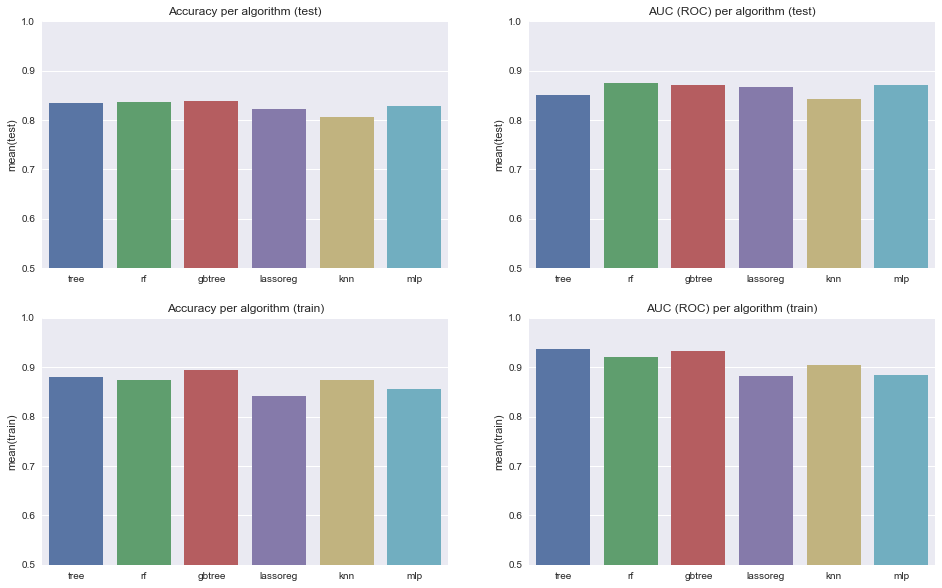

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.barplot(x=results_acc.index.tolist(), y='test',  data=results_acc, ax=axes[0,0]).set_title('Accuracy per algorithm (test)')
sns.barplot(x=results_auc.index.tolist(), y='test',  data=results_auc, ax=axes[0,1]).set_title('AUC (ROC) per algorithm (test)')
sns.barplot(x=results_acc.index.tolist(), y='train', data=results_acc, ax=axes[1,0]).set_title('Accuracy per algorithm (train)')
sns.barplot(x=results_auc.index.tolist(), y='train', data=results_auc, ax=axes[1,1]).set_title('AUC (ROC) per algorithm (train)')

axes[0,0].set_ylim(0.5,1)
axes[0,1].set_ylim(0.5,1)
axes[1,0].set_ylim(0.5,1)
axes[1,1].set_ylim(0.5,1)

plt.show()

### Observations
**What algorithm performs best?**
* First of all, performance between algorithms is not that different. After hypertuning they all get to ~80-83% accuracy and ~85-87% AUC
* In this case at least, conclusions on relative performance of the algorithms would not be different between accuracy and ROC as a metric
* RandomForest and GradientBoostedTree perform best overall

### 5.2 Error analysis

Error analysis can be helpful to improve model performance. I did some manual inspection and looked at the correlation matrix for any patterns. 

In [33]:
# looked at first 150 or so examples, showing 10 here for illustratative purposes
predictions['ACTUAL'] = df_target
predictions.head(10)

,tree,rf,gbtree,lassoreg,knn,mlp,ACTUAL
0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1
2,1,1,1,1,0,1,1
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0
8,1,1,1,0,1,1,1
9,1,1,1,1,1,1,1


### Observations (error analysis)
* The models are most often either all right or all completely wrong, except knn and lassoreg. These two tend to predict differently more often. So the models do seem to get the same individuals right or wrong, but there is some potentially helpful variation (esp. with knn and lassoreg)

### Correlation matrix

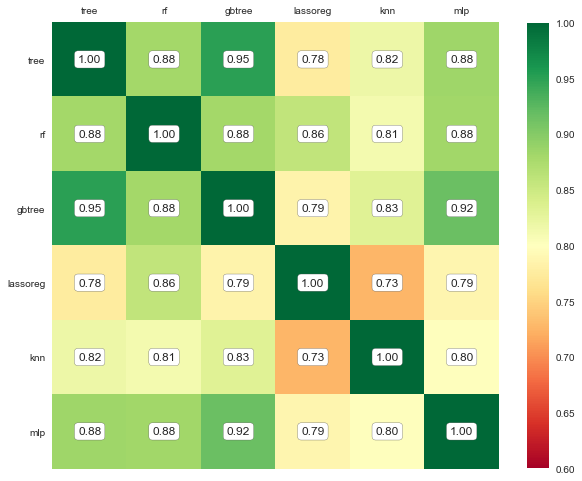

In [38]:
# create data for the correlation matrix
#predictions = predictions.drop('ACTUAL', axis = 1)
data = predictions.corr();

# create a figure object, add one subplot and make it a bit larger / easier to see
fig, ax = plt.subplots(figsize=(10, 10));
cax = ax.matshow(data, cmap='RdYlGn', vmin = 0.6, vmax = 1);

plt.xticks(range(len(data.columns)), data.columns);
plt.yticks(range(len(data.columns)), data.columns);

fig.colorbar(cax, fraction = 0.15, shrink = 0.82);

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.grid(axis='both', b=0)

# show result
plt.show();

### Observations
* Indeed see very high correlations for most algo's (88-95%), but lower correlations for lassoreg and knn with others (66-82%)
* (visually in graph above you see the more yellow-ish band for lassoreg/knn)

### 5.3 Develop an ensemble

In [132]:

predictions['ensemble'] = np.sum(predictions[clf_list], axis = 1) > 3 # Tie votes default to '1' based on 'tuning' range 1-6
predictions['target'] = df_target

print('accuracy ensemble: ', np.sum(predictions['ensemble'] == predictions['target']) / len(predictions))
    

accuracy ensemble:  0.8911335578


### Observations
* WOW! Thats quite an improvement (89% vs. 83.7% for the best individual model)
* The (slight) variation between model really works well. I.e. if one model 'slips up' the consensus of other models tends to correct

### 5.4 Insights from feature importances

It's interesting to explore which features had the largest impact on predicting whether a passenger survived or not. I'll compare feature importances across models below.

### Notes

* knn and mlp are hard to interpret re: feature importance
    * knn has no obvious metric of feature importance.(One could try and construct eg avg distance of predictions to features?)
    * mlp is differentiable and so it is possible to show which inputs will move the output most if slightly changed. However that's not trivial to construct and even thenfor a neural network, these interpretations are local

* Thus, we'll focus on tree, rf and gbtree, lassoreg below

### Feature importances

In [166]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [153]:
# df for results
f_imp= pd.DataFrame( index = df_data.columns, columns = ['lreg', 'tree', 'rf', 'gbtree'])

In [202]:
# Data
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

In [203]:
# LASSOREG (NORMALIZED)
# Create data format
df_data = standardize(df_data)

# Set parameters for GridSearch
parameters = {'C': [0.1, 1, 3, 10]}

# Initialize classifier
clf = GridSearchCV(estimator = LogisticRegression(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

print('best param: ', clf.best_estimator_)     

best param:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [204]:
clf = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(df_data, df_target)
f_imp['lreg'] = abs(clf.coef_[0])
f_imp['rank_lreg'] = f_imp['lreg'].rank(ascending= False)


In [167]:
# TREE
# Data
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

# Parameters
parameters = {'max_depth': [10], 'min_samples_leaf': [3]} # already optimized before

# Initialize classifier
clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

print('best param: ', clf.best_estimator_)  

best param:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [175]:
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
                             
clf.fit(df_data, df_target)
f_imp['tree'] = abs(clf.feature_importances_)
f_imp['rank_tree'] = f_imp['tree'].rank(ascending= False)

In [176]:
# RF
# Data
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

# Parameters
parameters = {'n_estimators': [10, 30, 100, 300],\
              'min_samples_leaf': [1, 3, 10, 30], 'max_depth': [3, 10, 30]}

# Initialize classifier
clf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

print('best param: ', clf.best_estimator_)         

best param:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [179]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
                             
clf.fit(df_data, df_target)
f_imp['rf'] = abs(clf.feature_importances_)
f_imp['rank_rf'] = f_imp['rf'].rank(ascending= False)

In [180]:
#GBTREE
# Data
df_data = df_train_numcat.drop(['Survived'], axis = 1)
df_target = df_train_numcat['Survived']

# Parameters
parameters = {'n_estimators': [3, 10, 30],\
              'min_samples_leaf': [1, 3, 10, 30], 'max_depth': [3, 10, 100, 300]}

# Initialize classifier
clf = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42), param_grid = parameters, cv=10)
clf.fit(df_data, df_target)

print('best param: ', clf.best_estimator_) 

best param:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=100,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


In [192]:
clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=100,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
                             
clf.fit(df_data, df_target)
f_imp['gbtree'] = abs(clf.feature_importances_)
f_imp['rank_gbtree'] = f_imp['gbtree'].rank(ascending= False)

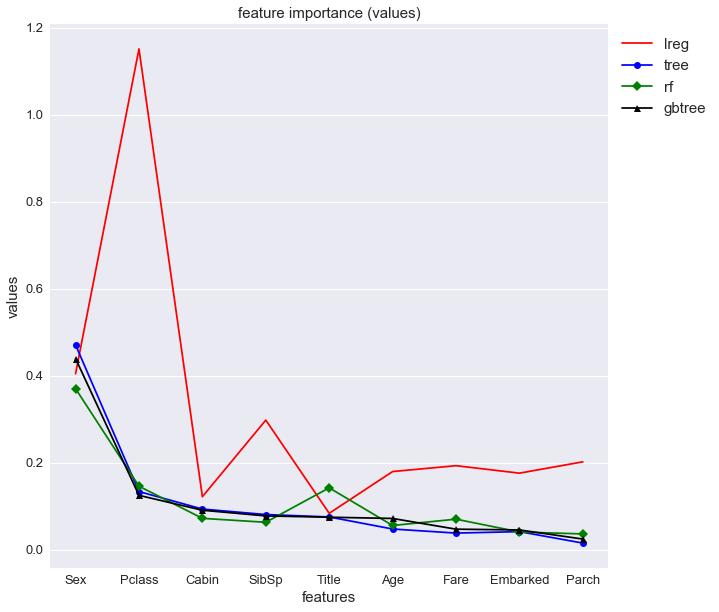

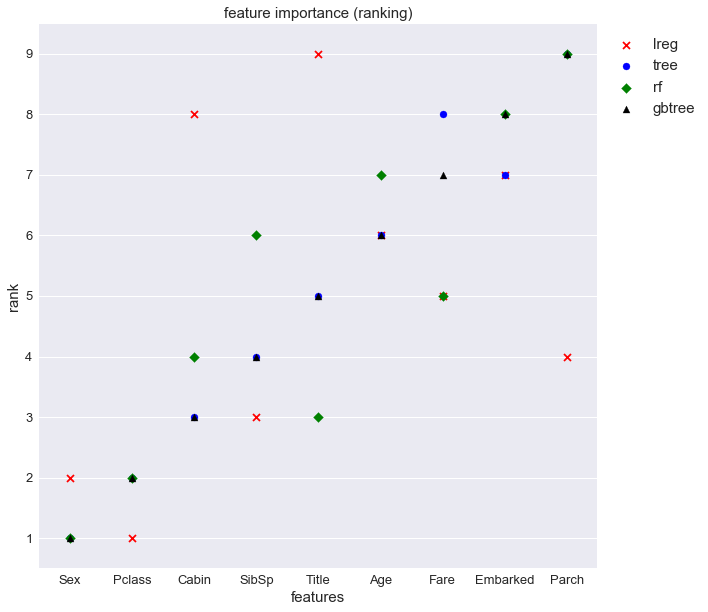

In [217]:
# Sort values
f_imp = f_imp.sort_values(by = 'gbtree', ascending = False)

# Create scatter plot values
fig, ax = plt.subplots(figsize = (10,10));

x = np.arange(1,10)
y_lreg = f_imp['lreg']
y_tree = f_imp['tree']
y_rf = f_imp['rf']
y_gbtree = f_imp['gbtree']

ax.plot(x, y_lreg, color = 'r', marker = 'x', label = 'lreg')
ax.plot(x, y_tree, color = 'b', marker = 'o',  label = 'tree')
ax.plot(x, y_rf, color = 'g', marker = 'D',  label = 'rf')
ax.plot(x, y_gbtree, color = 'black', marker = '^',  label = 'gbtree')

plt.title('feature importance (values)', fontsize = 15)
plt.ylabel('values', fontsize = 15)
plt.xlabel('features', fontsize = 15)
plt.xticks(x, f_imp.index.tolist())

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='x', b=0)

plt.tick_params(axis='both', which='major', labelsize=13)

plt.show()

# Create scatter plot rankings
fig, ax = plt.subplots(figsize = (10,10));

x = np.arange(1,10)
y_lreg = f_imp['rank_lreg']
y_tree = f_imp['rank_tree']
y_rf = f_imp['rank_rf']
y_gbtree = f_imp['rank_gbtree']

ax.scatter(x, y_lreg, color = 'r', marker = 'x', label = 'lreg')
ax.scatter(x, y_tree, color = 'b', marker = 'o',  label = 'tree')
ax.scatter(x, y_rf, color = 'g', marker = 'D',  label = 'rf')
ax.scatter(x, y_gbtree, color = 'black', marker = '^',  label = 'gbtree')

plt.title('feature importance (ranking)', fontsize = 15)
plt.ylabel('rank', fontsize = 15)
plt.xlabel('features', fontsize = 15)
plt.xticks(x, f_imp.index.tolist())

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize = 15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='x', b=0)

plt.tick_params(axis='both', which='major', labelsize=13)

plt.show()

### Observations

* The three tree-based models are very consistent in pointing to 'Sex' as most important by far. The differences in importance are less pronounced after that, but Pclass and Cabin are the next most important features. To interpret: women were most likely to survive. In addition, it mattered which Class you were staying (1st class was closer to deck) and which Cabin (certain cabin were closer to deck/life boats)
* The logistic regression model agrees with Sex and Pclass being most important, but Pclass is weighted much more. This might be artifical though, since its probably the interaction between Sex and Pclass that really matters. (eg. anyone, including women, from 3rd class never reached the deck as they were locked in)


* Overall, the tree based models are saying the same thing and logistic regression (depending a bit on data implementation) also largely agrees on the most important reasons. All models agree on 'Sex' being important.

* The more correct phrasing is not "Women and children first" but rather "Women from first class first"...